How do Nitya's best-fit $\phi$ values compare to those listed in the SGA?

In [14]:
import numpy as np

from astropy.table import Table
import astropy.constants as const
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib as mpl

import os
rotcurvepath = os.path.join(os.environ['HOME'], 'RotationCurves/spirals')
import sys
sys.path.insert(1, rotcurvepath)
from dark_matter_mass_v1 import rot_fit_BB

In [4]:
mpl.rc('font', size=12)

In [34]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

# Import data

## SGA

In [5]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [6]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## SGA MaNGA cross-match file

In [7]:
SGA_MaNGA = Table.read('../MaNGA_SGA_crossmatch_2022-06-28.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

plate,ifudsgn,plateifu,SGA_ID
int64,int64,str11,int64
8716,3703,8716-3703,927743
9086,6104,9086-6104,1003700
11967,1902,11967-1902,196166
8613,6104,8613-6104,376271
10001,3703,10001-3703,937846


## SDSS MaNGA best-fits

Nitya's fitting from 2023 on DR17

In [8]:
MaNGA_fits = Table.read('master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
                        format='ascii.commented_header')

MaNGA_fits[:5]

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_ID,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,smoothness_score,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,M3p5_map,M3p5_err_map,rho_bulge_map,rho_bulge_err_map,R_bulge_map,R_bulge_err_map,M90_disk_map,M90_disk_err_map,M3p5_disk_map,M3p5_disk_err_map,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,logHI200kms,WF50,WF50_err,map_fit_flag,DL_ttype,rabsmag_NSA,R90_kpc,MaNGA_sample,CMD_class,v_3p5,v_3p5_err,logH2_M,logH2_CG,logH2_CG_err
int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,448,450,51900,48157,51226,133.3710906116639,57.59842514455842,0.417013,69.2463,0.0392074,2685340000.0,1.560186343059074,0.8525269160441389,0.004661246847300842,61.88507825188626,0.07338042747869138,2.946989472970758,0.09848277794062997,38.7739389484797,0.022936739976051144,37.440940071078124,0.016138461970098106,183.15428191832711,2.8318738759310786,4.181226771589277,0.07058094055808059,2.2299464843830368,0.006099342053787376,10.637055736445056,9.856536145016422,11.185428134112588,10.663096428880776,318528356.25649077,10973819.90888883,1.1700697820493802,0.01234311518755433,10.054323200255043,8.681101900065409,10.119328135890797,8.780959524997495,9.852487564086914,10.529260284502032,10.529260284502032,10.350040435791016,-999.0,309.752973573684,50.84180796596384,1.5,6.564641952514648,-19.2112,5.614479609229095,2.0,1.0,183.14938552312165,24.91258446340628,-999.0,-999.0,-999.0
10001,12702,448,524,51900,48188,51261,133.68566986867248,57.48025032183927,0.598115,12.5169,0.0408108,4642460000.0,1.5619979358006435,0.6739844282455619,0.006739656007202572,188.3088174477578,0.16826186470866497,0.6765359119793715,0.23419562301556418,36.85326879733403,0.04204024887591865,37.98221005537202,0.05640746039294769,194.97775272347383,6.932242299930594,0.6629820156636723,0.04575759010348131,0.9585752877878831,0.07208969706038451,10.600037009816079,10.15080355502181,11.292909462167833,10.847252340042417,115971867.9868961,7747575.084882941,1.6956282295929506,0.03670610210595715,10.124313484194262,9.034999166941406,10.177811159857796,9.124034282826187,14.355437278747559,2.457986344552885,2.457986344552885,9.583724021911621,-999.0,273.50491644321835,6.866128229994085,3.5,4.730921268463135,-19.0722,8.515048082090281,2.0,2.0,168.30899596736322,29.53675151629983,-999.0,-999.0,-999.0
10001,12703,483,535,51924,55648,59078,136.01715996919202,57.09232917791099,0.378034,51.5052,0.0462094,9439710000.0,1.1414035570714935,0.868911357820688,0.0007131052643978732,56.79483322166177,0.08249999450764357,16.699456893928602,0.0963277859001372,36.558508375391675,0.020946818786307338,35.641571170832165,0.018071593708941423,369.9104377816068,1.1162754236338,1.0019694161891133,0.003716146716676395,2.2255004811754473,0.025995323685563534,11.32307263875663,10.727979027247507,11.98875372506019,11.44150293569664,494628915.16105384,13753186.951918408,1.3970129924747783,0.0114278522601265,10.546935338970071,9.081725877664413,10.558369569453301,9.103192513387299,14.743389129638672,57.98401438954021,57.98401438954021,9.775858879089355,-999.0,383.131393858277,32.519186623217024,2.5,4.756507873535156,-19.9387,9.902006982545116,2.0,1.0,347.745404077086,47.8247202374236,-999.0,-999.0,-999.0
10001,12704,483,456,51924,55616,59044,133.98996686918764,57.677967666915094,0.212315,81.0961,0.0141215,4218380000.0,1.2909390780165348,0.4055339772671592,0.0006001633102882991,85.11107958400

# Add SGA parameters to the cross-match table

In [13]:
SGA_MaNGA['R26'] = np.nan
SGA_MaNGA['BA'] = np.nan
SGA_MaNGA['PA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[SGA_MaNGA['SGA_ID'][i]]
    
    # Transfer R26 over to the SGA_MaNGA table
    SGA_MaNGA['R26'][i] = 0.5*SGA['D26'][SGA_idx]
    
    # Transfer b/a over to the SGA_MaNGA table
    SGA_MaNGA['BA'][i] = SGA['BA'][SGA_idx]
    
    # Transfer phi over to the SGA_MaNGA table
    SGA_MaNGA['PA'][i] = SGA['PA'][SGA_idx]

# Add the MaNGA best-fit values to the cross-match table

In [20]:
SGA_MaNGA['Vmax_map'] = np.nan
SGA_MaNGA['Vmax_err_map'] = np.nan
SGA_MaNGA['Rturn_map'] = np.nan
SGA_MaNGA['alpha_map'] = np.nan

SGA_MaNGA['ba_map'] = np.nan
SGA_MaNGA['ba_err_map'] = np.nan
SGA_MaNGA['ba_NSA'] = np.nan

SGA_MaNGA['phi_map'] = np.nan
SGA_MaNGA['phi_err_map'] = np.nan
SGA_MaNGA['phi_NSA'] = np.nan

SGA_MaNGA['Z_NSA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    gal_id = SGA_MaNGA['plateifu'][i]
    
    # Find galaxy row in MaNGA fits table
    plate_bool = MaNGA_fits['MaNGA_plate'] == SGA_MaNGA['plate'][i]
    ifu_bool = MaNGA_fits['MaNGA_IFU'] == SGA_MaNGA['ifudsgn'][i]
    
    i_fit = plate_bool & ifu_bool
    
    # Copy best-fit parameter values from fit table to galaxy table
    if (np.sum(i_fit) > 0): #and (gal_id not in []):
        SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['Vmax_map'][i_fit]
        SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['Vmax_err_map'][i_fit]
        SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['Rturn_map'][i_fit]
        SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha_map'][i_fit]
        
        SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba_map'][i_fit]
        SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err_map'][i_fit]
        SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['NSA_ba'][i_fit]
        
        SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi_map'][i_fit]
        SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err_map'][i_fit]
        SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['NSA_phi'][i_fit]
        
        SGA_MaNGA['Z_NSA'][i] = MaNGA_fits['NSA_redshift'][i_fit]
        
# Flip all -99 values to NaN
SGA_MaNGA['Vmax_map'][SGA_MaNGA['Vmax_map'] == -999] = np.nan
SGA_MaNGA['phi_err_map'][SGA_MaNGA['phi_err_map'] == -999] = np.nan

# Remove galaxies with bad MaNGA fits

In [15]:
# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy = SGA_MaNGA['Z_NSA']*c/H0
R26_kpc = dist_to_galaxy.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to(u.rad))

# 2 - Compute V(R26)
SGA_MaNGA['Vfit_R26'] = rot_fit_BB(R26_kpc.data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

# 3 - Filter out those with V(R26) < 0.9Vmax
goodVmax = SGA_MaNGA['Vfit_R26'] >= 0.9*SGA_MaNGA['Vmax_map']

# 4 - Filter out those with Vmax > 1000 km/s
lowVmax = SGA_MaNGA['Vmax_map'] < 1000.

# 5 - Filter out those with alpha > 99
good_alpha = SGA_MaNGA['alpha_map'] < 99.

# 6 - Filter out those with large uncertainties in Vmax
goodVmax2 = SGA_MaNGA['Vmax_err_map']/SGA_MaNGA['Vmax_map'] <= 2

final_sample = goodVmax & lowVmax & good_alpha & goodVmax2

/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))
/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: divide by zero encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))
/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: divide by zero encountered in true_divide
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


In [16]:
len(SGA_MaNGA[final_sample])

3926

# Identify galaxies with $i > 45^\circ$

These objects are not included in the TF calibration.

In [35]:
SGA_MaNGA['cosi2'] = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
SGA_MaNGA['cosi2'][SGA_MaNGA['cosi2'] < 0] = 0

In [36]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = SGA_MaNGA['cosi2'] <= cosi2_max

final_sample_edge = final_sample & edge

In [38]:
len(SGA_MaNGA[final_sample_edge])

2795

# Plots

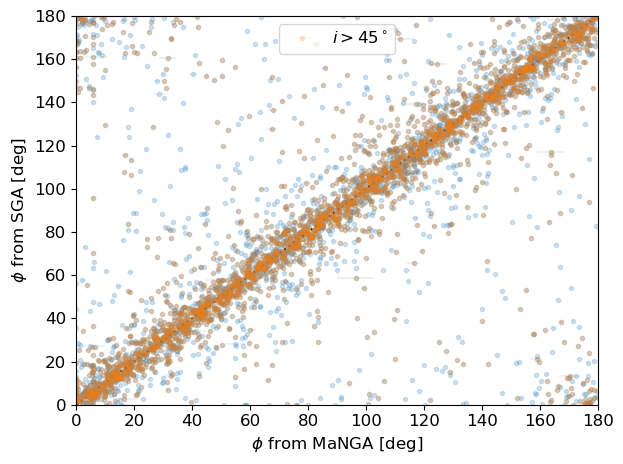

In [41]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             fmt='.', 
             ecolor='lightskyblue', 
             alpha=0.2)
plt.errorbar(SGA_MaNGA['phi_map'][final_sample_edge]%180., SGA_MaNGA['PA'][final_sample_edge], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample_edge], 
             fmt='.', 
             ecolor='bisque', 
             alpha=0.2, 
             label='$i > 45^\circ$')
plt.plot([0,180], [0,180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.legend()
             
plt.xlabel('$\phi$ from MaNGA [deg]')
plt.ylabel('$\phi$ from SGA [deg]');

In [24]:
SGA_MaNGA['delta_phi'] = SGA_MaNGA['phi_map']%180. - SGA_MaNGA['PA']

SGA_MaNGA['delta_phi'][np.abs(SGA_MaNGA['delta_phi']) >= 90.] = 180. - np.abs(SGA_MaNGA['delta_phi'][np.abs(SGA_MaNGA['delta_phi']) >= 90.])

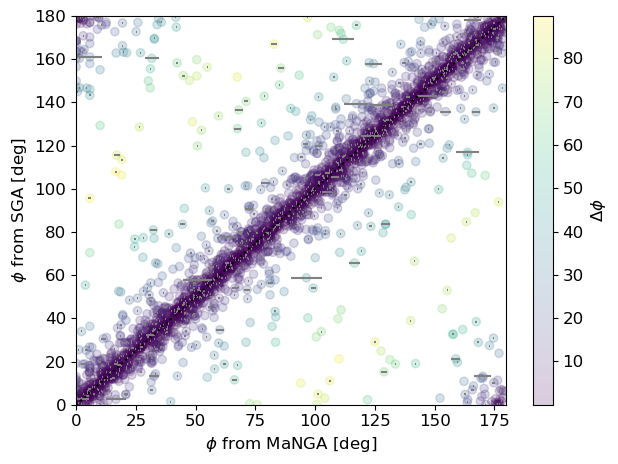

In [42]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['phi_map'][final_sample_edge]%180., SGA_MaNGA['PA'][final_sample_edge], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample_edge], 
             fmt='None',
             ecolor='gray')
plt.scatter(SGA_MaNGA['phi_map'][final_sample_edge]%180., SGA_MaNGA['PA'][final_sample_edge], 
            c=np.abs(SGA_MaNGA['delta_phi'][final_sample_edge]), 
            alpha=0.2)
plt.plot([0,180], [0,180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.colorbar(label='$\Delta \phi$')

plt.xlabel('$\phi$ from MaNGA [deg]')
plt.ylabel('$\phi$ from SGA [deg]');

In [43]:
np.std(SGA_MaNGA['delta_phi'][final_sample]), np.std(SGA_MaNGA['delta_phi'][final_sample_edge])

(20.255538572565587, 16.050668609683523)

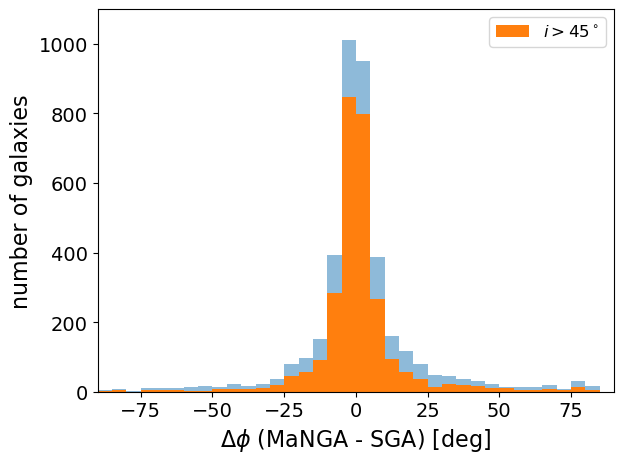

In [46]:
plt.figure(tight_layout=True)

plt.hist(SGA_MaNGA['delta_phi'][final_sample], 
         bins=np.arange(-90, 90, 5), 
         alpha=0.5)
plt.hist(SGA_MaNGA['delta_phi'][final_sample_edge], 
         bins=np.arange(-90, 90, 5), 
         label='$i > 45^\circ$')

plt.xlim([-90, 90])
plt.ylim([0, 1100])

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

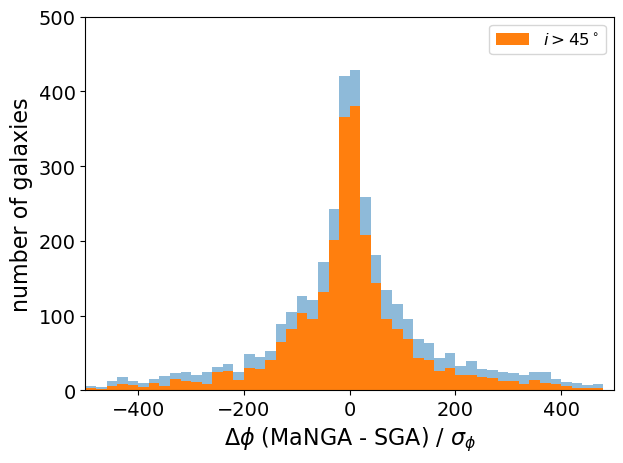

In [53]:
plt.figure(tight_layout=True)

plt.hist(SGA_MaNGA['delta_phi'][final_sample]/SGA_MaNGA['phi_err_map'][final_sample], 
         bins=np.arange(-500, 500, 20), 
         alpha=0.5)
plt.hist(SGA_MaNGA['delta_phi'][final_sample_edge]/SGA_MaNGA['phi_err_map'][final_sample_edge], 
         bins=np.arange(-500, 500, 20), 
         label='$i > 45^\circ$')

plt.xlim([-500, 500])
plt.ylim([0, 500])

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) / $\sigma_\phi$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

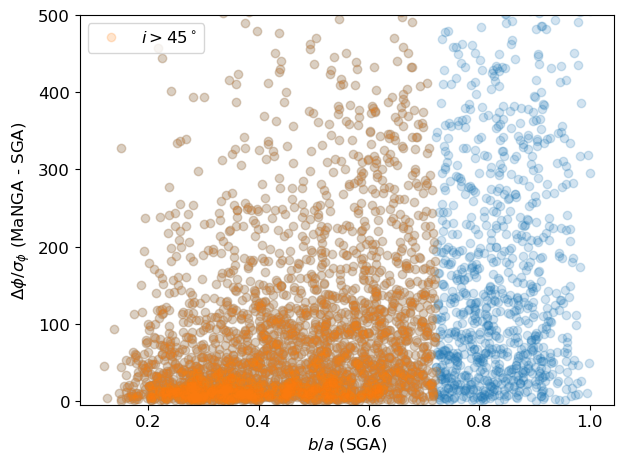

In [61]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'][final_sample], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample])/SGA_MaNGA['phi_err_map'][final_sample], 
         'o', 
         alpha=0.2)
plt.plot(SGA_MaNGA['BA'][final_sample_edge], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample_edge])/SGA_MaNGA['phi_err_map'][final_sample_edge], 
         'o', 
         alpha=0.2, 
         label='$i > 45^\circ$')

plt.ylim([-5, 500])

plt.legend()

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi / \sigma_\phi$ (MaNGA - SGA)');

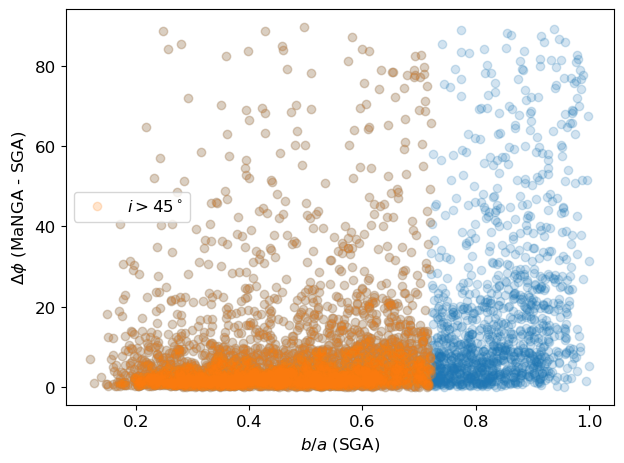

In [64]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'][final_sample], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
         'o', 
         alpha=0.2)
plt.plot(SGA_MaNGA['BA'][final_sample_edge], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample_edge]), 
         'o', 
         alpha=0.2, 
         label='$i > 45^\circ$')

# plt.ylim([-5, 45])

plt.legend()

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi$ (MaNGA - SGA)');

# Write $\Delta \phi$ and $b/a$ to file

In [65]:
SGA_MaNGA[['delta_phi', 'BA']].write('SGA_MaNGAdr17-fits_dphi-20240611.txt', 
                                     format='ascii.commented_header')